In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")

!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=d6f07e0fd45e76d72c7b75b7a1af2114bce56db3648c2ef0e16a7fc8682e0e53
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.11 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 15143, done.
remote: Counting objects

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Download Dataset

In [ ]:
!pip install roboflow

VERSION = 2

from roboflow import Roboflow
rf = Roboflow(api_key="7tISFpxELvGi0rjvqo2E")
project = rf.workspace("shiitake-harvest").project("shiitake-harvest")
dataset = project.version(2).download("coco")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=0864171692baf0e5feeec7086913022d87c059b2e58bd2c436a192d124737a1b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Shiitake-Harvest-2 in coco:: 100%|██████████| 151/151 [00:00<00:00, 267.95it/s]


## Register the datasets

In [ ]:

from detectron2.data.datasets import register_coco_instances

register_coco_instances("shiitake_train", {}, f"/content/Shiitake-Harvest-2/train/_annotations.coco.json", f"/content/Shiitake-Harvest-2/train/")
register_coco_instances("shiitake_valid", {}, f"/content/Shiitake-Harvest-2/valid/_annotations.coco.json", f"/content/Shiitake-Harvest-2/valid/")
register_coco_instances("shiitake_test", {}, f"/content/Shiitake-Harvest-2/test/_annotations.coco.json", f"/content/Shiitake-Harvest-2/test/")


To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



WARNING [07/07 11:20:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/07 11:20:48 d2.data.datasets.coco]: Loaded 118 images in COCO format from /content/Shiitake-Harvest-2/train/_annotations.coco.json


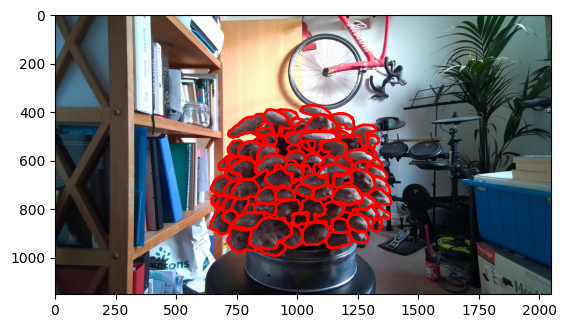

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

dataset_train = DatasetCatalog.get("shiitake_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

# Train model

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("shiitake_train",)
cfg.DATASETS.TEST = ("shiitake_test",) # setting the test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/ShiitakeHarvest/weights/Shiitake_3000.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[07/07 11:40:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ShiitakeHarvest/weights/Shiitake_3000.pth ...


In [ ]:
# From pre-trained weights

from detectron2.data.detection_utils import read_image

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/ShiitakeHarvest/weights/Shiitake_3000.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/07 11:40:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ShiitakeHarvest/weights/Shiitake_3000.pth ...


# Checking depth values

different_backgroundBelow2_00530
Results will be stored in /content/test
Instance 0: depth range is 0.0 to 467.0
Instance 1: depth range is 0.0 to 482.0
Instance 2: depth range is 0.0 to 477.0
Instance 3: depth range is 0.0 to 469.0
Instance 4: depth range is 0.0 to 487.0
Instance 5: depth range is 0.0 to 502.0
Instance 6: depth range is 0.0 to 484.0
Instance 7: depth range is 0.0 to 493.0
Instance 8: depth range is 0.0 to 485.0
Instance 9: depth range is 0.0 to 519.0
Instance 10: depth range is 0.0 to 466.0
Instance 11: depth range is 0.0 to 466.0
Instance 12: depth range is 0.0 to 477.0
Instance 13: depth range is 0.0 to 501.0
Instance 14: depth range is 0.0 to 465.0
Instance 15: depth range is 0.0 to 3094.0
Instance 16: depth range is 0.0 to 481.0
Instance 17: depth range is 0.0 to 500.0
Instance 18: depth range is 0.0 to 534.0
Instance 19: depth range is 0.0 to 494.0
Instance 20: depth range is 0.0 to 468.0
Instance 21: depth range is 0.0 to 526.0
Instance 22: depth range is 0.0 to

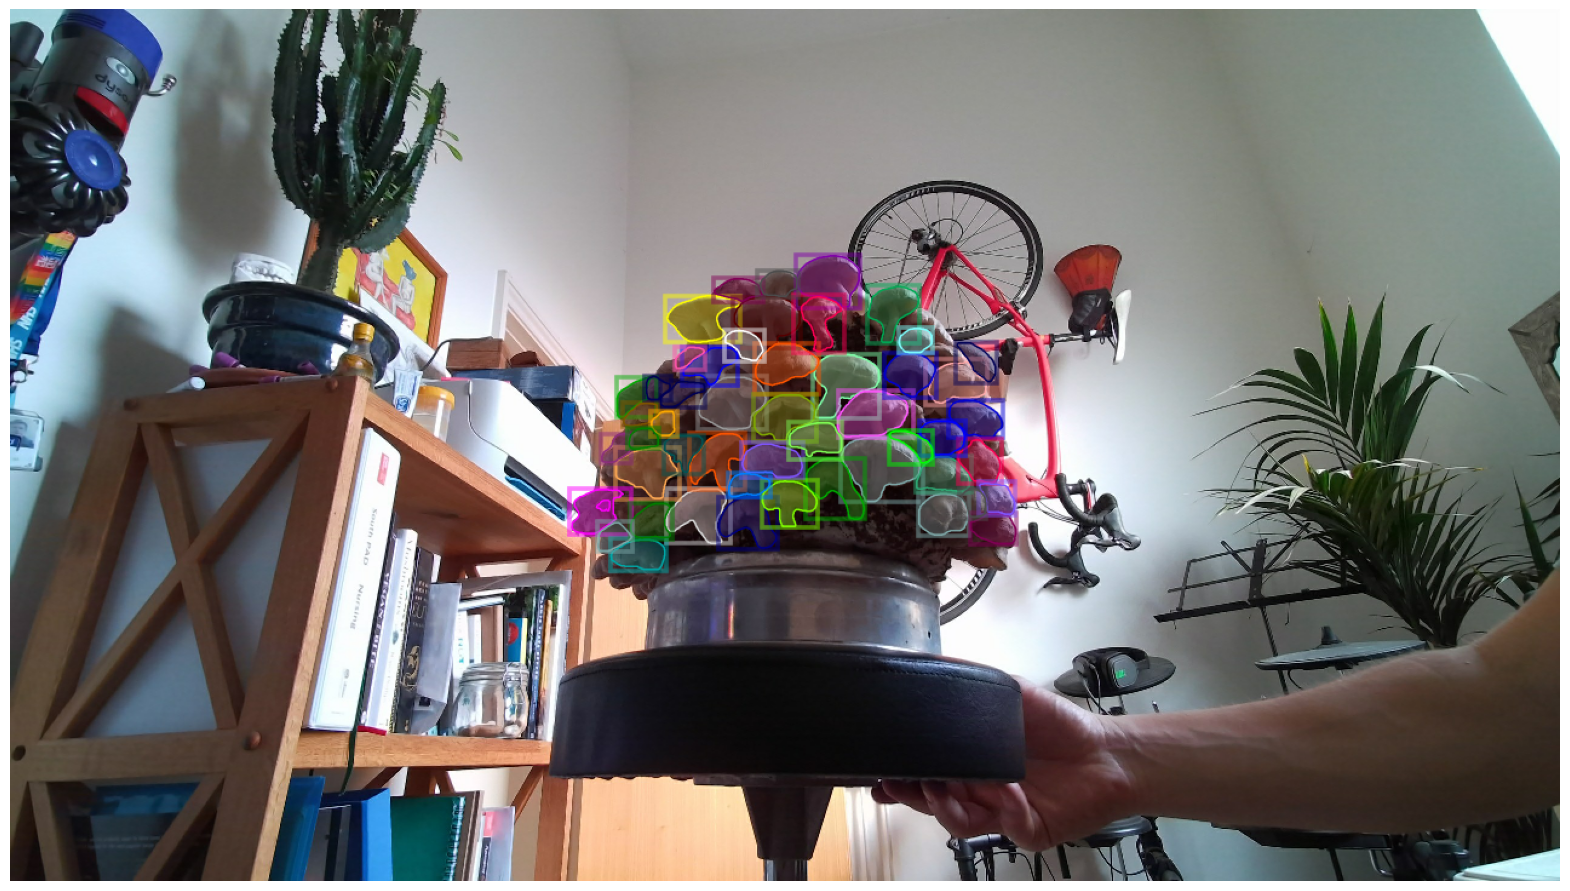

In [ ]:
import cv2
import numpy as np
from PIL import Image
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog

def run_inference(predictor, img, depth_image, image_name):
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=MetadataCatalog.get("shiitake_test"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW)
    v = v.overlay_instances(boxes=outputs["instances"].pred_boxes.to("cpu"),
                            masks=outputs["instances"].pred_masks.to("cpu"),
                            labels=None,
                            assigned_colors=None,
                            alpha=0.3)

    if os.path.isdir("/content/test"):
      print("Results will be stored in /content/test")
    else:
      os.mkdir(os.path.join("/content", "test"))
      print("Test folder created - Results will be stored in /content/test")

    pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
    for i, instance_mask in enumerate(pred_masks):
        instance_mask = instance_mask.astype(np.uint8)
        masked_depth_image = cv2.bitwise_and(depth_image, depth_image, mask=instance_mask)

        # get the range of depth values within this masked region
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(masked_depth_image)
        print(f"Instance {i}: depth range is {min_val} to {max_val}")

        img = Image.fromarray(masked_depth_image)
        img.save(f"/content/test/{image_name}_{i}.png")

    return v.get_image()[:, :, ::-1]


image_path = "/content/drive/MyDrive/ShiitakeHarvest/Different_background_below2/Output/color/different_backgroundBelow2_00530.jpg"
depth_image_path = "/content/drive/MyDrive/ShiitakeHarvest/Different_background_below2/Output/depth/different_backgroundBelow2_00530.png"

image = cv2.imread(image_path)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

# extract the filename from the image path
base_image_name = os.path.basename(image_path)
image_name, _ = os.path.splitext(base_image_name)
print(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

output = run_inference(predictor, image_rgb, depth_image, image_name)

plt.figure(figsize=(20, 20))
plt.imshow(output)
plt.axis("off")
plt.show()


different_backgroundBelow2_00530
Results will be stored in /content/test2


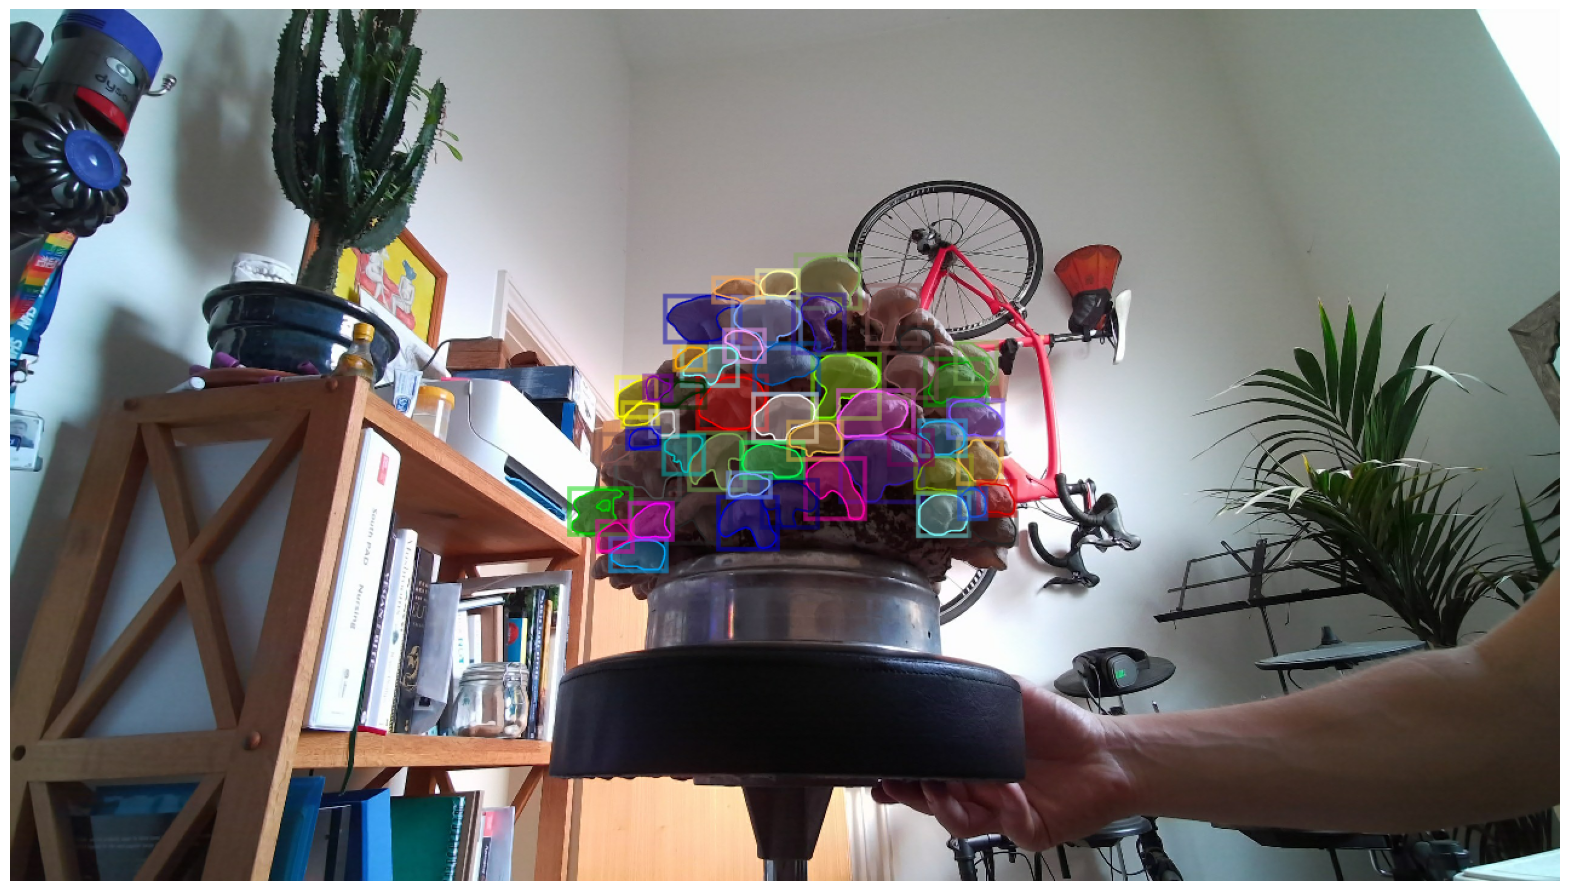

In [ ]:
import cv2
import numpy as np
from PIL import Image
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog

def run_inference(predictor, img, depth_image, image_name):
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=MetadataCatalog.get("shiitake_test"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW)
    v = v.overlay_instances(boxes=outputs["instances"].pred_boxes.to("cpu"),
                            masks=outputs["instances"].pred_masks.to("cpu"),
                            labels=None,
                            assigned_colors=None,
                            alpha=0.3)


    if os.path.isdir("/content/test2"):
      print("Results will be stored in /content/test2")
    else:
      os.mkdir(os.path.join("/content", "test2"))
      print("Test folder created - Results will be stored in /content/test2")


    pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
    # depth_image = cv2.cvtColor(depth_image, cv2.COLOR_BGR2GRAY)  # Convert depth image to grayscale
    for i, instance_mask in enumerate(pred_masks):
        instance_mask = instance_mask.astype(np.uint8)

        # Apply mask to the depth image and save
        masked_depth_image = cv2.bitwise_and(depth_image, depth_image, mask=instance_mask)
        img_depth = Image.fromarray(masked_depth_image)
        img_depth.save(f"/content/test2/{image_name}_depth_{i}.png")

        # Apply mask to the color image and save
        masked_color_image = np.zeros_like(img)
        for j in range(3):  # Apply mask to each channel separately
            masked_color_image[:, :, j] = cv2.bitwise_and(img[:, :, j], img[:, :, j], mask=instance_mask)
        img_color = Image.fromarray(masked_color_image)
        img_color.save(f"/content/test2/{image_name}_color_{i}.png")

    return v.get_image()[:, :, ::-1]


image_path = "/content/drive/MyDrive/ShiitakeHarvest/Different_background_below2/Output/color/different_backgroundBelow2_00530.jpg"
depth_image_path = "/content/drive/MyDrive/ShiitakeHarvest/Different_background_below2/Output/depth/different_backgroundBelow2_00530.png"

image = cv2.imread(image_path)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

# extract the filename from the image path
base_image_name = os.path.basename(image_path)
image_name, _ = os.path.splitext(base_image_name)
print(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

output = run_inference(predictor, image_rgb, depth_image, image_name)


plt.figure(figsize=(20, 20))  # Adjust the figure size as per your requirement
plt.imshow(output)
plt.axis("off")
plt.show()



WARNING [07/07 11:51:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/07 11:51:30 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/Shiitake-Harvest-2/test/_annotations.coco.json


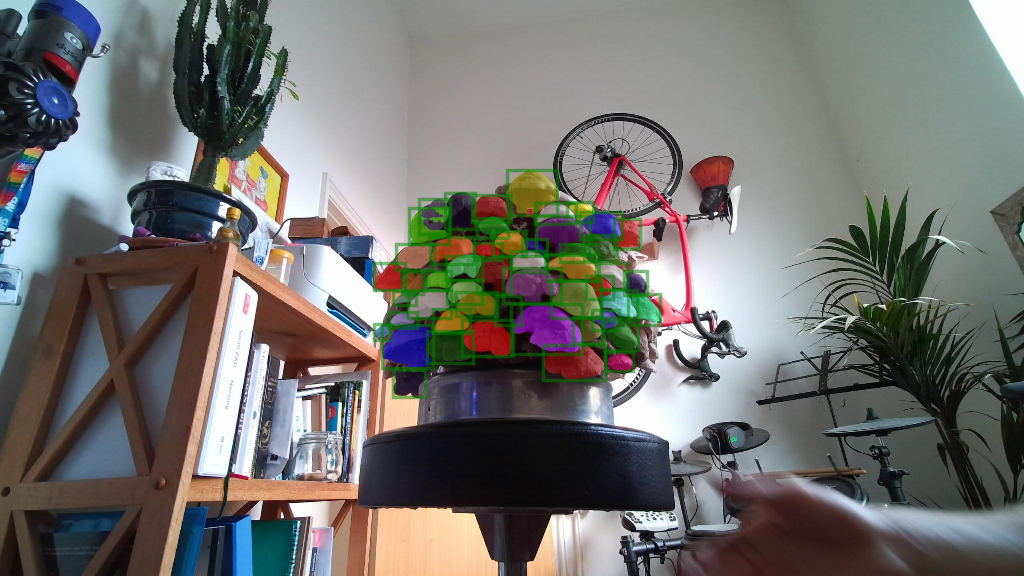

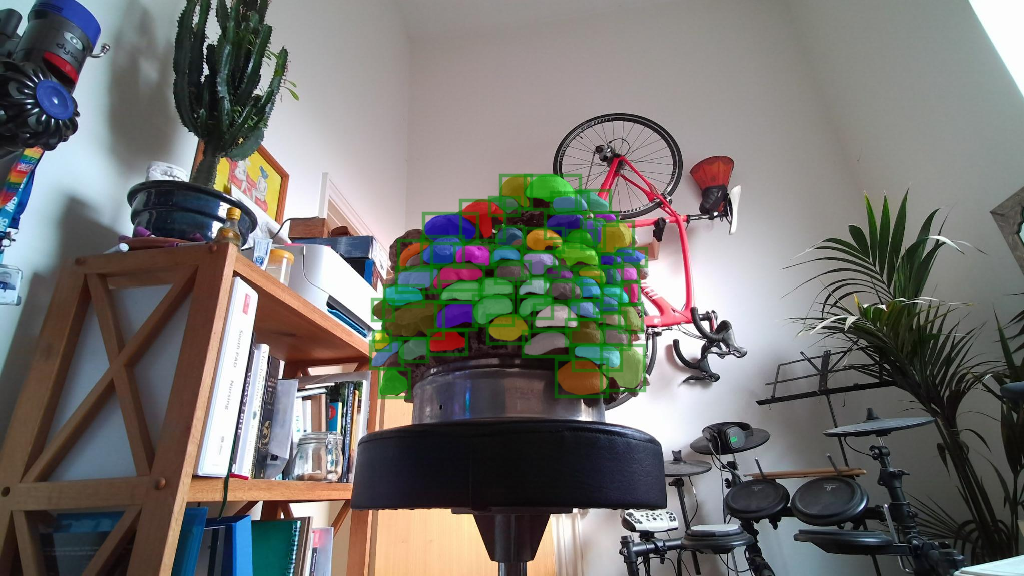

In [ ]:
import cv2
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("shiitake_test")
for d in random.sample(dataset_dicts, 2):
# for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("shiitake_test"),   # pass metadata of the dataset for visualizer
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )

    # Boxes
    for box in outputs["instances"].pred_boxes.to('cpu'):
        v.draw_box(box)
    # Masks
    for mask in outputs["instances"].pred_masks.to('cpu'):
        v.draw_soft_mask(mask)
    v = v.get_output()
    img =  v.get_image()[:, :, ::-1]
    cv2_imshow(img)
